# import packages

In [187]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import s, l, f, te
from pygam import LinearGAM as linear_gam

# set seaborn look

In [188]:
sns.set(context = "notebook", style = "darkgrid", palette = "colorblind")

# read tabular data from html

In [189]:
biden_favorability_recent, biden_favorability_full = pd.read_html("https://www.realclearpolitics.com/epolls/other/joe_biden_favorableunfavorable-6677.html")

# rename columns

In [190]:
biden_favorability_full.columns = ["poll", "poll_period", "sample_size_population", "favorable_pct", "unfavorable_pct", "net_favorable_pct"]

# remove rcp average row

In [191]:
biden_favorability_full = biden_favorability_full.loc[biden_favorability_full["poll"] != "RCP\xa0Average", ]

# remove "Tie" from net favorability variable

In [192]:
biden_favorability_full["net_favorable_pct"] = biden_favorability_full["net_favorable_pct"].astype(str).str.replace("Tie", "0")

# parse dates

In [193]:
biden_favorability_full[["start_date", "end_date"]] = biden_favorability_full["poll_period"].str.split(" - ").apply(pd.Series)

# parse months and days from date strings

In [194]:
# start month and day
biden_favorability_full[["start_month", "start_day"]] = biden_favorability_full["start_date"].str.split("/").apply(pd.Series)

# end month and day
biden_favorability_full[["end_month", "end_day"]] = biden_favorability_full["end_date"].str.split("/").apply(pd.Series)

# parse sample size and polling population

In [195]:
biden_favorability_full[["sample_size", "polling_population"]] = biden_favorability_full["sample_size_population"].str.split(" ").apply(pd.Series)

# replace "," in sample size
biden_favorability_full["sample_size"] = biden_favorability_full["sample_size"].astype(str).str.replace(",", "")

# cumulative sum of december polling start and end dates

In [196]:
biden_favorability_full["start_december_cumsum"] = (biden_favorability_full["start_month"] == "12").cumsum()
biden_favorability_full["end_december_cumsum"] = (biden_favorability_full["end_month"] == "12").cumsum()

# use cumulative sum to determine year
This is the dumbest solution in the notebook

In [197]:
# recode cumulative sum integer to year string
def cumsum2year(x):
    if x == 0:
        return "2020"
    elif x > 7 and x < 10:
        return "2019"
    else:
        return "2018"

# start adn end year
biden_favorability_full["start_year"] = biden_favorability_full["start_december_cumsum"].apply(cumsum2year)
biden_favorability_full["end_year"] = biden_favorability_full["start_december_cumsum"].apply(cumsum2year)

# create start and end dates and their midpoint

In [198]:
biden_favorability_full["start_date"] = pd.to_datetime(biden_favorability_full[["start_year", "start_month", "start_day"]].apply(lambda row: "/".join(row.values.astype(str)), axis = 1))
biden_favorability_full["end_date"] = pd.to_datetime(biden_favorability_full[["end_year", "end_month", "end_day"]].apply(lambda row: "/".join(row.values.astype(str)), axis = 1))
biden_favorability_full["median_date"] = biden_favorability_full["start_date"] + (biden_favorability_full["end_date"] - biden_favorability_full["start_date"]) / 2

# change data types

In [199]:
biden_favorability_full[["net_favorable_pct", "sample_size", "start_year", "start_month", "start_day", "end_year", "end_month", "end_day"]] = biden_favorability_full[["net_favorable_pct", "sample_size", "start_year", "start_month", "start_day", "end_year", "end_month", "end_day"]].astype(int)

# reset index to median date

In [200]:
biden_favorability_full = biden_favorability_full.sort_values("median_date", ascending = True).reset_index(drop = True)

# fit linear GAM

In [201]:
# linear GAM fit
gam_fit = linear_gam(s(0)).fit(biden_favorability_full["median_date"], biden_favorability_full["net_favorable_pct"], weights = biden_favorability_full["sample_size"])

# add predictions to data frame
biden_favorability_full["net_favorable_pct_hat"] = gam_fit.predict(biden_favorability_full["median_date"])

# add confidence intervals
biden_favorability_full = (biden_favorability_full.join(pd.DataFrame(
    gam_fit.confidence_intervals(biden_favorability_full["median_date"], width = 0.95),
    columns = ["lower_pct_hat", "upper_pct_hat"]
)))

# root mean squared error for linear GAM

In [202]:
# define rmse function
def rmse(predicted, observed):
    return np.sqrt(((predicted - observed) ** 2).mean())

# print rmse
("Root Mean Squared Error (RMSE) = {}%".
     format(rmse(predicted = biden_favorability_full["net_favorable_pct_hat"], 
                 observed = biden_favorability_full["net_favorable_pct"]).round(0))
)

'Root Mean Squared Error (RMSE) = 6.0%'

# add 7-day rolling average to data frame, weighted by 7-day rolling average sample size

In [203]:
# define weighted rolling average function
def wra(x, w, window, min_periods):
    return (x * w / w.rolling(window = window, min_periods = min_periods).sum()).rolling(window = window, min_periods = min_periods).sum()

biden_favorability_full["net_favorable_pct_7dra"] = wra(biden_favorability_full["net_favorable_pct"], biden_favorability_full["sample_size"], window = 7, min_periods = 7)


# root mean squared error for 7-day rolling average

In [204]:
# print rmse
("Root Mean Squared Error (RMSE) = {}%".
     format(rmse(predicted = biden_favorability_full["net_favorable_pct_7dra"], 
                 observed = biden_favorability_full["net_favorable_pct"]).round(0))
)

'Root Mean Squared Error (RMSE) = 6.0%'

# plot GAM predictions compared to 7-day rolling average

Text(0, 0.5, '')

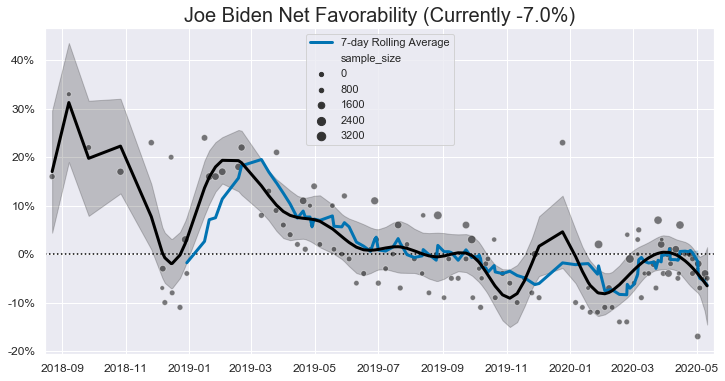

In [205]:
# save figure and axes objects
figure, axes = plt.subplots(figsize = (12, 6))

# scatterplot and lineplot using lowess fit above
axes.axhline(y = 0, linestyle = "dotted", c = "black")
sns.lineplot(x = "median_date", y = "net_favorable_pct_7dra", data = biden_favorability_full, label = "7-day Rolling Average", linewidth = 3)
sns.lineplot(y = "net_favorable_pct_hat", x = "median_date", data = biden_favorability_full, linewidth = 3, color = "black")
plt.fill_between(biden_favorability_full["median_date"], biden_favorability_full["lower_pct_hat"], biden_favorability_full["upper_pct_hat"], color = "black", alpha = 0.20)
sns.scatterplot(x = "median_date", y = "net_favorable_pct", data = biden_favorability_full, color = "black", size = "sample_size", alpha = 0.50)

# set x-axis limits
axes.set_xlim(biden_favorability_full["median_date"].min() - np.timedelta64(1, "W"), biden_favorability_full["median_date"].max() + np.timedelta64(1, "W"))

# set y-axis label format at percentage %
axes.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

# tick fonts
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# set titles
axes.set_title("Joe Biden Net Favorability (Currently {}%)".format(biden_favorability_full["net_favorable_pct_hat"][biden_favorability_full.end_date == biden_favorability_full.end_date.max()].round(0).squeeze()), fontsize = 20)
axes.set_xlabel(xlabel = None)
axes.set_ylabel(ylabel = None)

# print table

In [206]:
biden_favorability_full.loc[:, ["poll", "poll_period", "median_date", "sample_size", "polling_population", "favorable_pct", "unfavorable_pct", "net_favorable_pct", "net_favorable_pct_7dra", "net_favorable_pct_hat", "lower_pct_hat", "upper_pct_hat"]].sort_values("median_date", ascending = False).head(n = 7)

,poll,poll_period,median_date,sample_size,polling_population,favorable_pct,unfavorable_pct,net_favorable_pct,net_favorable_pct_7dra,net_favorable_pct_hat,lower_pct_hat,upper_pct_hat
124,Economist/YouGovYouGov,5/10 - 5/12,2020-05-11 00:00:00,1175,RV,46.0,51.0,-5,-6.390542,-6.556162,-14.544297,1.431973
123,Politico/Morning ConsultPolitico,5/8 - 5/10,2020-05-09 00:00:00,1994,RV,43.0,47.0,-4,-5.899995,-5.971522,-12.140495,0.197451
122,CNNCNN,5/7 - 5/10,2020-05-08 12:00:00,1001,RV,45.0,50.0,-5,-5.568714,-5.827653,-11.627342,-0.027964
121,Economist/YouGovYouGov,5/3 - 5/5,2020-05-04 00:00:00,1209,RV,45.0,52.0,-7,-5.002986,-4.579484,-8.595658,-0.563309
120,Politico/Morning ConsultPolitico,5/2 - 5/3,2020-05-02 12:00:00,1987,RV,43.0,45.0,-2,-4.142663,-4.184090,-8.107519,-0.260660
119,CNBCCNBC,5/1 - 5/3,2020-05-02 00:00:00,1489,LV,36.0,53.0,-17,-3.729908,-4.054810,-7.979192,-0.130429
118,MonmouthMonmouth,4/30 - 5/4,2020-05-02 00:00:00,739,RV,41.0,44.0,-3,0.671963,-4.054810,-7.979192,-0.130429
